<a href="https://colab.research.google.com/github/LemuelKL/CIFAR10-HOG-SVM/blob/main/CIFAR10_HOG_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm
from statistics import mean
from joblib import dump, load
from tensorflow import keras
from skimage.feature import hog
from skimage import data, exposure
import matplotlib.pyplot as plt
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
assert y_train.shape == (50000,)
assert y_test.shape == (10000,)

In [ ]:
def preprocess(xs):
    hog_imgs = []
    for x in tqdm(xs):
        gray = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY) / 255
        fd = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                    	cells_per_block=(2, 2))
        hog_imgs.append(fd)
    return np.array(hog_imgs)

In [ ]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

100%|██████████| 10000/10000 [00:11<00:00, 872.29it/s]


In [ ]:
print(x_train.shape)
print(x_test.shape)

(50000, 324)
(10000, 324)


In [ ]:
pca = PCA(0.8)
pca.fit(x_train)
print(pca.n_components_)

66


In [ ]:
pipe = Pipeline([('standardscaler', StandardScaler()), ('pca', PCA(0.8)), ('rbfsvc', SVC(kernel='rbf', C=10, cache_size=10000))])
pipe.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=0.8)),
                ('rbfsvc', SVC(C=10, cache_size=10000))])

In [ ]:
dump(pipe, 'pipe.joblib')

['pipe.joblib']

In [ ]:
pipe = load('pipe.joblib')

In [ ]:
pipe.score(x_test, y_test)

0.6199

In [ ]:
y_pred = pipe.predict(x_test)

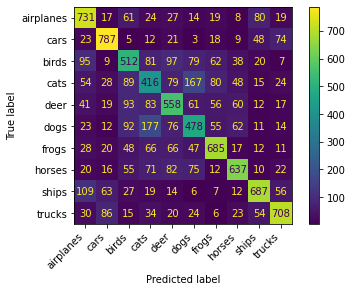

In [ ]:
color = 'white'
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks'])
disp.plot()
plt.xticks(rotation=45, ha='right')
plt.show()